In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd

print(pd.__version__)
!python --version

1.5.3
Python 3.8.5


In [2]:
mnist = fetch_openml('mnist_784', version=1, parser='auto')

In [3]:
print(mnist.DESCR) # o dataset normalmente fica em cache em $HOME/scikit_learn_data. No meu caso no windows: C:\Users\josen\scikit_learn_data

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
mnist.keys() #dict python

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist.data, mnist.target
print(X.shape)
print(y.shape)
#X é um dataframe pandas, y é uma serie pandas

(70000, 784)
(70000,)


In [6]:
# Um outro dataset mais simples
#from sklearn.datasets import load_digits
#df = load_digits()
#print(df.DESCR)

In [7]:
print(y.value_counts()) # para ver quantas amostras o dataset possui por classe

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: class, dtype: int64


In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
some_digit = X.loc[0,:] #X[0] - será usado mais a frente na predição
# converter de serie pandas para numpy (na verdade já vê a serie como um array)
some_digit_np = some_digit.to_numpy()
some_digit_image = some_digit_np.reshape(28,28)

(-0.5, 27.5, 27.5, -0.5)

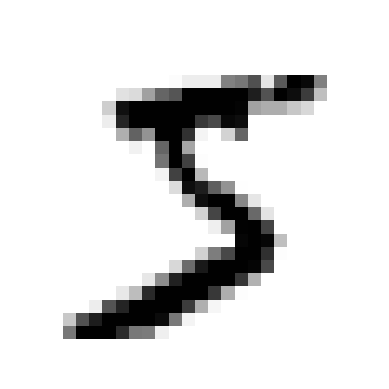

In [10]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')

In [11]:
y[0] #verifica se y[0] é o dígito 5 mesmo

'5'

In [12]:
import numpy as np
# como o label é uma string, vamos converter para número, pois os algoritmos ML trabalham com números
y = y.astype(np.uint8) # unsigned int de 1 byte, o famoso unsigned char do C

In [13]:
# o dataset MNIST já é separado em conjunto de treino e teste, onde o conjunto de treino está embaralhado (shuffle),
# o que é bom neste caso

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [14]:
print(y_test.value_counts())

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: class, dtype: int64


In [15]:
# vamos exemplificar treinando um classificador binário para reconhecer apenas o número 5, portanto, classes 5 e não 5
y_train_5 = (y_train == 5) # 1(true) para o 5, 0(false) para os demais
y_test_5 = (y_test == 5)

In [16]:
"""
escolher um classificador (knn, svm, naivebayes, nn, sgd, decisiontree etc.). Vamos usar o SGD (stochastic gradient descent), um
classificador que lida bem com conjunto grande de dados e lida com instâncias de treinamento uma por vez, de forma independente, sendo
boa opção para aprendizado online. Em sua configuração padrão é um modelo linear regularizado (L2) - SVM
""" 

from sklearn.linear_model import SGDClassifier
model_sgd = SGDClassifier(random_state=42) #se quiser reproduzir os resultados
model_sgd.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [21]:
# vamos agora usar para detectar imagens com o número alvo
model_sgd.predict([some_digit])

c:\Users\josen\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

#### Validação cruzada

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(model_sgd, X_train, y_train_5, cv=5,scoring='accuracy')

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

##### Vamos usar o cross_val_predict para obter predições feitas em cada teste de fold na validação cruzada e usar isto para uma matriz de confusão

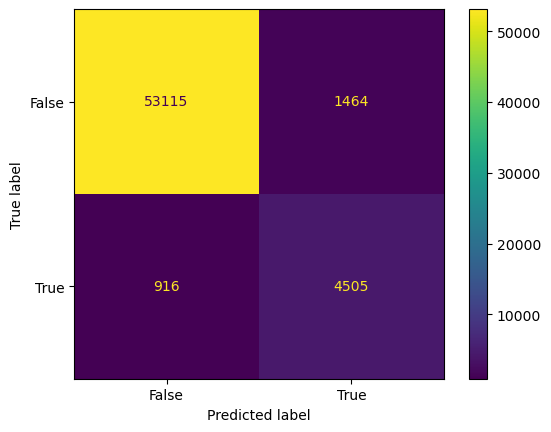

In [19]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(model_sgd, X_train, y_train_5, cv=5)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=y_train_5, y_pred=y_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_sgd.classes_)
disp.plot()

In [27]:
y_scores = model_sgd.decision_function([some_digit])
print(y_scores)

# definindo um threshold = 0 (padrão do SGDClassifier com predict())
thresh = 0

y_some_digit_pred = (y_scores > thresh)
print(y_some_digit_pred) # TRUE

# aumentando o threshold para 8000 dará False, diminuindo a revocação (o classificador perde esta imagem de 5)
thresh = 3000
y_some_digit_pred = (y_scores > thresh)
print(y_some_digit_pred) # FALSE


[2164.22030239]
[ True]
[False]


c:\Users\josen\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


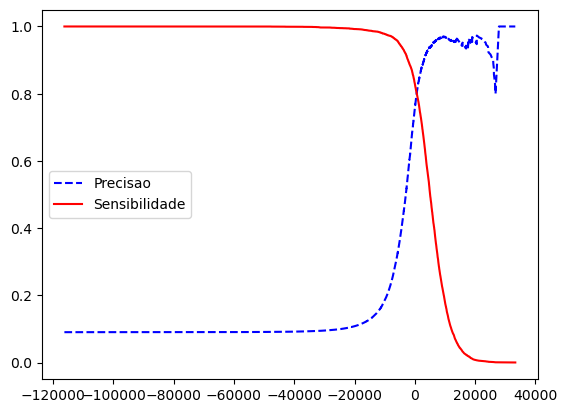

In [31]:
y_scores = cross_val_predict(model_sgd, X_train, y_train_5, cv=5, method='decision_function')

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precisao')
    plt.plot(thresholds, recalls[:-1], 'r-', label='Sensibilidade')
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [34]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision) #3045

y_train_pred_90 = (y_scores >= threshold_90_precision)
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred_90)) #90%
print(recall_score(y_train_5, y_train_pred_90)) #65%

3045.9258227053647
0.9002016129032258
0.6589190186312488


##### Curva ROC

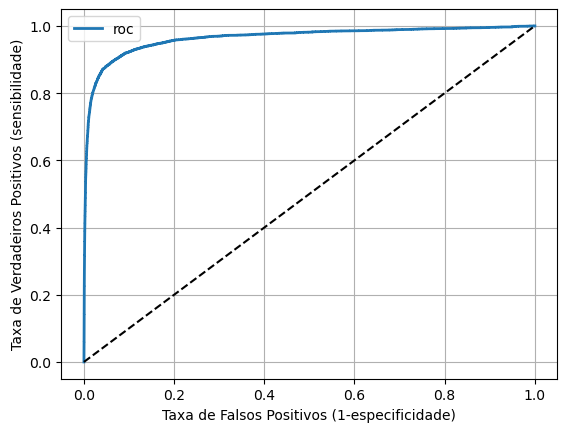

In [38]:
from sklearn.metrics import roc_curve
tfp, tvp, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(tfp, tvp, label='roc'):
    plt.plot(tfp,tvp,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.legend()
    plt.grid()
    plt.xlabel('Taxa de Falsos Positivos (1-especificidade)')
    plt.ylabel('Taxa de Verdadeiros Positivos (sensibilidade)')

plot_roc_curve(tfp, tvp)
plt.show()

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9648211175804801

##### Vamos comparar com um Random Forest? Embora Random Forest não tenha decision_function, tem predict_proba (probabilidade de pertença de cada classe). Pode-se usar no _predict() o method='predict_proba'

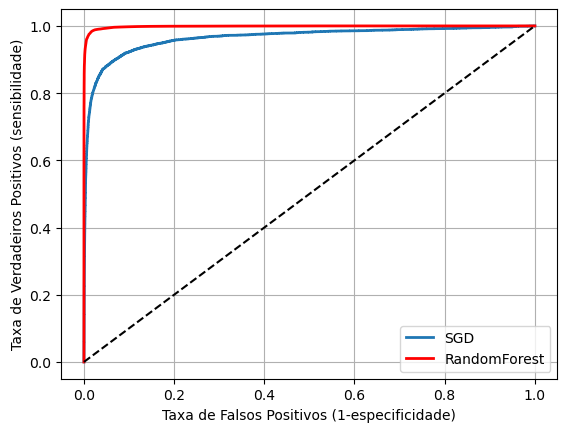

In [40]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=42)

y_probas_rf = cross_val_predict(model_rf, X_train, y_train_5, cv=5, method='predict_proba')

y_scores_rf = y_probas_rf[:,1] # ou seja as probabilidades da classe positiva (5)
tfp_rf, tvp_rf, thresholds_rf = roc_curve(y_train_5, y_scores_rf)

def plot_roc_curve(tfp_1, tvp_1, tfp_2, tvp_2, label_1, label_2):
    plt.plot(tfp_1,tvp_1, linewidth=2, label=label_1)
    plt.plot(tfp_2,tvp_2, 'r', linewidth=2, label=label_2)
    plt.plot([0,1],[0,1],'k--')
    plt.legend()
    plt.grid()
    plt.xlabel('Taxa de Falsos Positivos (1-especificidade)')
    plt.ylabel('Taxa de Verdadeiros Positivos (sensibilidade)')

plot_roc_curve(tfp, tvp, tfp_rf, tvp_rf, 'SGD', 'RandomForest')
plt.show()

In [41]:
roc_auc_score(y_train_5, y_scores_rf)

0.998402186461512